In [146]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [147]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [148]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [149]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [150]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare (autoload_with=engine)

In [151]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [152]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [153]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [154]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Extract the date string from the list
most_recent_date = most_recent_date[0]  # Get the first element from the list
most_recent_date

'2017-08-23'

In [155]:
print(type(most_recent_date))  # This should output <class 'str'>

<class 'str'>


<Axes: xlabel='Date', ylabel='Inches'>

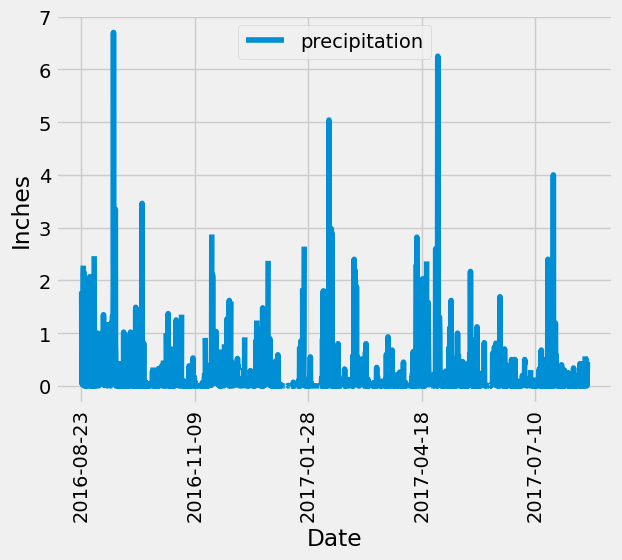

In [156]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= one_year_ago).all()
  
 # Save the query results as a Pandas DataFrame. Explicitly set the column names   
df_precipitation = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_precipitation = df_precipitation.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df_precipitation.plot(
    x="date", 
    y="precipitation",
    xlabel="Date",
    ylabel="Inches",
    rot=90,
    )

In [157]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_precipitation.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [158]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [159]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


# Group by station and count the number of measurements
station_counts = (
    session.query(Measurement.station, func.count(Measurement.id))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())

    .all()
)

# Print the results
for station, count in station_counts:
    print(f"Station: {station}, Observation Count: {count}")

Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511


In [160]:
# Given 'USC00519281' is the most active station
active_station = 'USC00519281'

# Query for temperature statistics
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == active_station).all()


# Print the results
print(f"Lowest Temperature: {temp_stats[0][0]}")
print(f"Highest Temperature: {temp_stats[0][1]}")
print(f"Average Temperature: {round(temp_stats[0][2], 2)}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


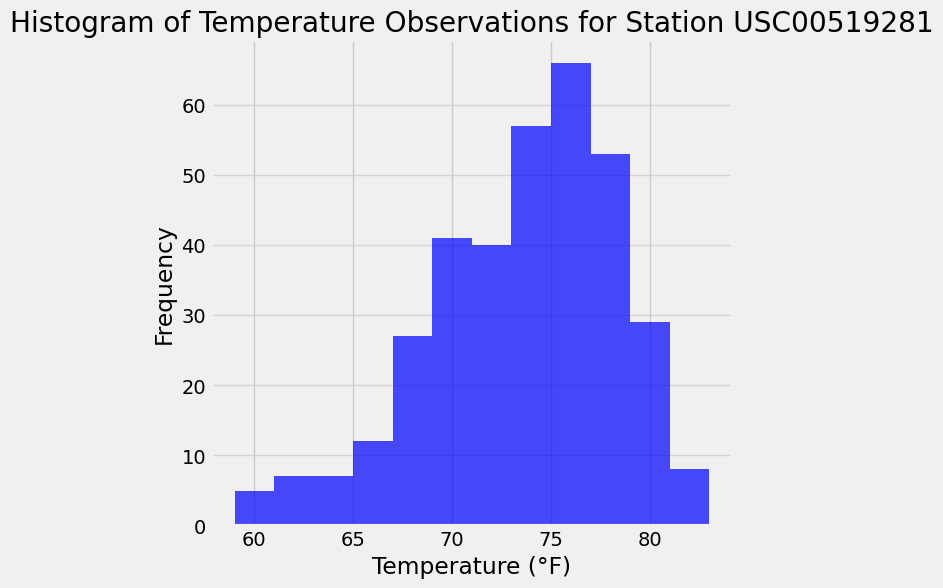

In [161]:
# Define the most active station ID
active_station = 'USC00519281'

# Calculate the date one year ago from the most recent date
most_recent_date = pd.read_sql("SELECT MAX(date) FROM measurement", engine).iloc[0, 0]
last_year_date = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Query to get the last 12 months of temperature observation data for the active station
query = f"""
SELECT date, tobs 
FROM measurement 
WHERE station = '{active_station}' 
AND date >= '{last_year_date.strftime('%Y-%m-%d')}'
"""

# Load the query results into a Pandas DataFrame
tobs_df = pd.read_sql(query, engine)

# Plot the results as a histogram
plt.figure(figsize=(6,6))
plt.hist(tobs_df['tobs'], bins=12, color='blue', alpha=0.7)
plt.title('Histogram of Temperature Observations for Station USC00519281')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

# Close Session

In [162]:
# Close Session
session.close()